# Exploratory Data Analysis (EDA) - Dataset Meme Multimodal
## Klasifikasi Self-harm vs Non Self-harm

Notebook ini melakukan analisis mendalam terhadap dataset yang berisi:
- Teks dari meme (hasil OCR)
- Label klasifikasi (Self-harm / Non Self-harm)
- Confidence score anotator
- Reasoning anotator
- File gambar meme

---

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text processing
from wordcloud import WordCloud
from collections import Counter
import re

# Image processing
from PIL import Image
import os
from pathlib import Path

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load Dataset

In [33]:
# Load dataset
df = pd.read_csv('../Dataset/labels.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

Dataset loaded successfully!
Shape: 1508 rows × 5 columns


In [3]:
# Display first few rows
print(" First 5 rows of the dataset:")
df.head()

 First 5 rows of the dataset:


,Teks_Terlihat,Label,Confidence,Reasoning,File_Name
0,FRIDAY NIGHT MONDAY MORNING,Non Self-harm,0.85,The image presents a humorous comparison of appearances without any indications of self-harm or ...,0001.jpg
1,STARTED FROM THE BOTTOM NOW I'M HERE,Non Self-harm,0.95,The image and text convey a positive and motivational message without any indications of self-harm.,0002.jpg
2,"""SECRET""",Non Self-harm,0.95,"The image features a fictional character and a badge, which does not indicate self-harm or relat...",0003.jpg
3,SMILES NOW WORTH 100 FANTASY POINTS,Non Self-harm,0.95,"The image contains positive and playful text related to sports, with no indications of self-harm.",0004.jpg
4,BETTER GRAB A HAM BECAUSE THERE MIGHT NOT BE ANY TURKEY LEFT BY CHRISTMAS Haha.. Well True.. rus...,Non Self-harm,0.95,The content is humorous and does not contain any indications of self-harm or suggestive themes.,0005.jpg


In [4]:
# Dataset info
print(" Dataset Information:")
df.info()

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Teks_Terlihat  1508 non-null   object 
 1   Label          1508 non-null   object 
 2   Confidence     1508 non-null   float64
 3   Reasoning      1508 non-null   object 
 4   File_Name      1508 non-null   object 
dtypes: float64(1), object(4)
memory usage: 59.0+ KB


## 3. Analisis Struktur Data

In [34]:
# Check missing values
print(" Missing Values Analysis:")


missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("✓ No missing values found!")



 Missing Values Analysis:
✓ No missing values found!


In [7]:
# Check for duplicates
print(" Duplicate Analysis:")


total_duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

if 'File_Name' in df.columns:
    file_duplicates = df['File_Name'].duplicated().sum()
    print(f"Duplicate file names: {file_duplicates}")

if total_duplicates > 0:
    print("\n Warning: Duplicates found in dataset!")
    print("\nDuplicate rows:")
    print(df[df.duplicated(keep=False)].sort_values(by=df.columns[0]))
else:
    print("\n✓ No duplicates found!")


 Duplicate Analysis:
Total duplicate rows: 0
Duplicate file names: 0

✓ No duplicates found!


In [8]:
# Data types and unique values
print(" Data Types and Unique Values:")

data_overview = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Non_Null_Count': df.count(),
    'Unique_Values': df.nunique(),
    'Sample_Value': [df[col].iloc[0] if len(df) > 0 else None for col in df.columns]
})

print(data_overview.to_string(index=False))


 Data Types and Unique Values:
       Column Data_Type  Non_Null_Count  Unique_Values                                                                                                     Sample_Value
Teks_Terlihat    object            1508           1486                                                                                      FRIDAY NIGHT MONDAY MORNING
        Label    object            1508              2                                                                                                    Non Self-harm
   Confidence   float64            1508              9                                                                                                             0.85
    Reasoning    object            1508           1486 The image presents a humorous comparison of appearances without any indications of self-harm or harmful context.
    File_Name    object            1508           1508                                                                           

## 4. Analisis Distribusi Label

In [9]:
# Label distribution
print(" Label Distribution:")


label_counts = df['Label'].value_counts()
label_percentages = df['Label'].value_counts(normalize=True) * 100

label_summary = pd.DataFrame({
    'Label': label_counts.index,
    'Count': label_counts.values,
    'Percentage': label_percentages.values.round(2)
})

print(label_summary.to_string(index=False))
print(f"\nTotal samples: {len(df)}")

# Check balance
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print(" Dataset is IMBALANCED - consider resampling techniques")
else:
    print("✓ Dataset is relatively BALANCED")



 Label Distribution:
        Label  Count  Percentage
Non Self-harm    852        56.5
    Self-harm    656        43.5

Total samples: 1508

Imbalance ratio: 1.30:1
✓ Dataset is relatively BALANCED


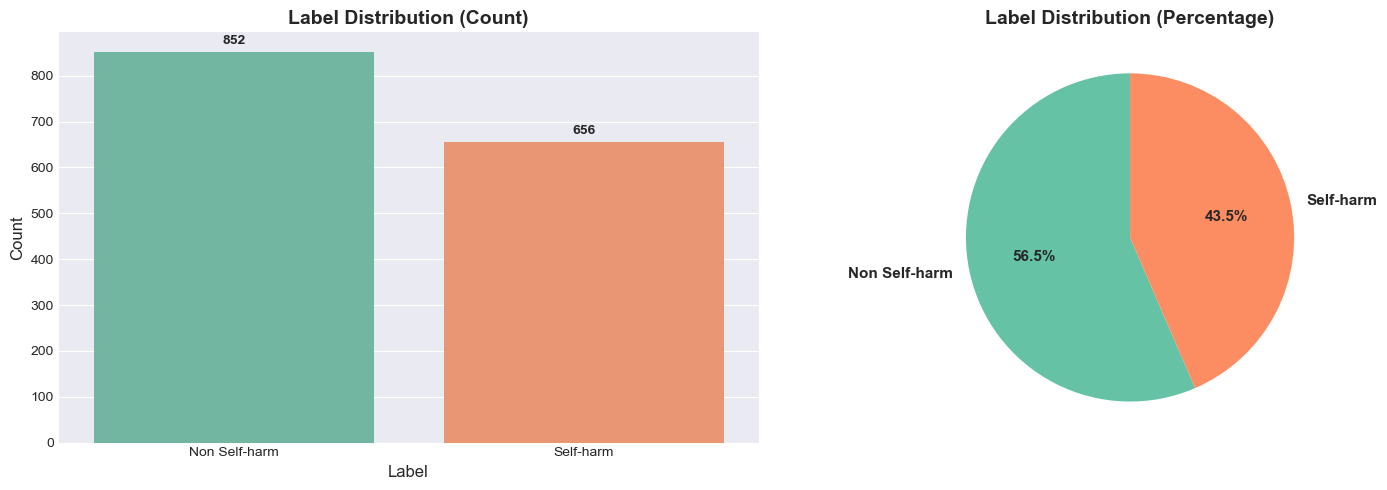

In [10]:
# Visualize label distribution - Bar chart
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette='Set2')
axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Add value labels on bars
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = sns.color_palette('Set2', len(label_counts))
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Analisis Confidence Score

In [12]:
# Confidence statistics
print(" Confidence Score Statistics:")
confidence_stats = df.groupby('Label')['Confidence'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(3)

print(confidence_stats)

print(f"\nOverall confidence statistics:")
print(f"  Mean: {df['Confidence'].mean():.3f}")
print(f"  Median: {df['Confidence'].median():.3f}")
print(f"  Std: {df['Confidence'].std():.3f}")
print(f"  Min: {df['Confidence'].min():.3f}")
print(f"  Max: {df['Confidence'].max():.3f}")


 Confidence Score Statistics:
               count   mean    std   min   max  median
Label                                                 
Non Self-harm    852  0.920  0.050  0.70  1.00    0.95
Self-harm        656  0.883  0.064  0.65  0.95    0.85

Overall confidence statistics:
  Mean: 0.904
  Median: 0.950
  Std: 0.059
  Min: 0.650
  Max: 1.000


## 6. Analisis Teks (Teks_Terlihat)

In [15]:
# Calculate text length metrics
print(" Text Length Analysis:")


# Handle missing text values
df['Teks_Terlihat'] = df['Teks_Terlihat'].fillna('')

# Calculate metrics
df['text_length_chars'] = df['Teks_Terlihat'].astype(str).apply(len)
df['text_length_words'] = df['Teks_Terlihat'].astype(str).apply(lambda x: len(x.split()))
df['avg_word_length'] = df.apply(
    lambda row: row['text_length_chars'] / row['text_length_words'] if row['text_length_words'] > 0 else 0, 
    axis=1
)

# Overall statistics
print("Overall text statistics:")
print(f"  Average characters: {df['text_length_chars'].mean():.2f}")
print(f"  Average words: {df['text_length_words'].mean():.2f}")
print(f"  Average word length: {df['avg_word_length'].mean():.2f}")

# Statistics by label
print("\nText statistics by label:")
text_stats = df.groupby('Label').agg({
    'text_length_chars': ['mean', 'median', 'std'],
    'text_length_words': ['mean', 'median', 'std']
}).round(2)

print(text_stats)

 Text Length Analysis:
Overall text statistics:
  Average characters: 63.47
  Average words: 12.10
  Average word length: 5.31

Text statistics by label:
              text_length_chars               text_length_words             
                           mean median    std              mean median   std
Label                                                                       
Non Self-harm             67.71   59.0  41.06             12.72   11.0  7.44
Self-harm                 57.97   54.0  27.82             11.28   11.0  5.56


## 7. Analisis Gambar (File_Name)

In [24]:
# Analyze image files
print(" Image File Analysis:")

# Define possible image directories
image_dirs = ['images', 'memes', 'data', '.', 'dataset']
image_path = None

# Try to find image directory
for dir_name in image_dirs:
    if os.path.exists(dir_name):
        image_path = dir_name
        break

if image_path:
    print(f"✓ Image directory found: {image_path}")
    
    # Check file existence
    existing_files = 0
    missing_files = []
    
    for file_name in df['File_Name']:
        file_path = os.path.join(image_path, file_name)
        if os.path.exists(file_path):
            existing_files += 1
        else:
            missing_files.append(file_name)
    
    print(f"\nFile statistics:")
    print(f"  Total files in dataset: {len(df)}")
    print(f"  Existing files: {existing_files}")
    print(f"  Missing files: {len(missing_files)}")
    print(f"  Availability: {existing_files/len(df)*100:.2f}%")
    
    if missing_files and len(missing_files) <= 10:
        print(f"\n Missing files: {missing_files}")
    elif len(missing_files) > 10:
        print(f"\n First 10 missing files: {missing_files[:10]}")
else:
    print(" Image directory not found. Please specify the correct path.")
    print("Tried directories:", image_dirs)



 Image File Analysis:
✓ Image directory found: .

File statistics:
  Total files in dataset: 1508
  Existing files: 0
  Missing files: 1508
  Availability: 0.00%

 First 10 missing files: ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg']
